In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import src.pipeline as pipeline

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [107]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_gender = pd.read_csv('data/gender_submission.csv')

In [226]:
df_train.head()
print(df_train.shape)

(891, 14)


## Data Cleaning
There's likely some missing data in here which we can actually see a few examples of in the `head` output above. Let's check out the rest of the dataset and identify where we may have other `NaN` values. From there, we'll have to think about either imputting or dropping them.

In [109]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [110]:
df_train.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [111]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Looks like there's quite a few with missing ages which we can easily impute with a median age. Cabin has a lot of NAs as well and perhaps not so easily imputted. We'll set that aside for now. Embarked (where passenger got on ship) also has a few missing values, but it's unclear if this feature would be important in survival rates to begin with. We'll hold off on doing anything for now, but it's good to be aware of these missing values.

## Exploratory Data Analysis
Let's see if we can find any meaningful patterns in the data. We'll pick out some attributes that seem like they could be candidates to separate the data and see what we find. Sex, pclass, age, sibsp, parch, fare, and cabin seem like they could be important factors here, so we'll start looking at those. 

### Sex (`Sex`)

        Survived
Sex             
female  0.742038
male    0.188908


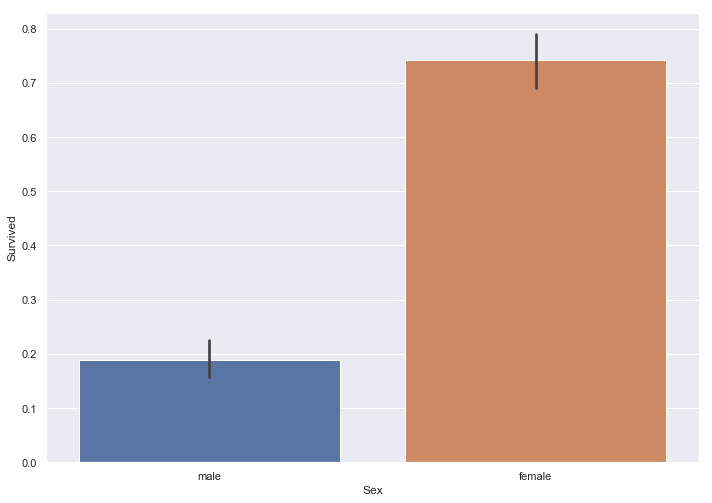

In [113]:
# difference in survival by sex
df_survival_mf = df_train[['Sex', 'Survived']].groupby(['Sex']).mean()
ax = sns.barplot(x='Sex', y='Survived', data=df_train) 
print(df_survival_mf)

Wow. Well, right off the bat, we see that sex seems to show a huge difference in survival rates. This will be a key feature for whatever model we choose. Let's take a look at `Pclass` and see if perhaps adding that makes much of a difference.

### Age (`Age`)
It will be interesting to see how age figures into survival rates. I would expect the young children and those in advanced age to have poor survival rates given they would have a much more difficulty with prolonged exposure to the frigid waters where the Titanic sank. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2668fdd8>]],
      dtype=object)

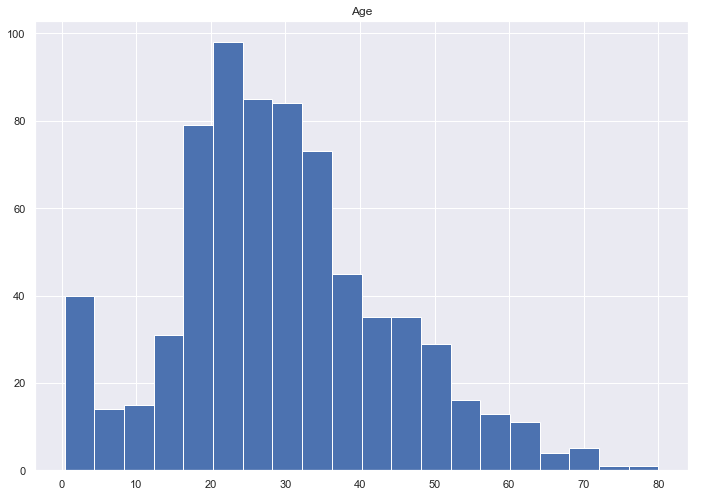

In [114]:
df_train.hist(column='Age', bins=20)

The distribution is basically right-skewed unimodal and about what you'd expect with the majority of passengers between 20-40 years old.

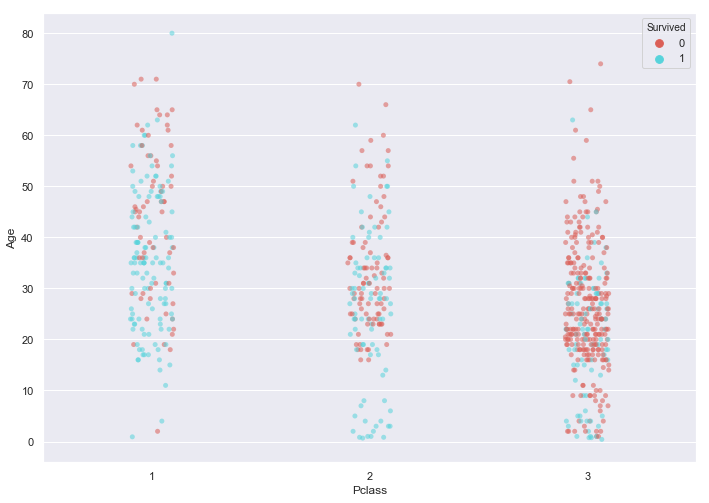

In [115]:
ax = sns.stripplot(x='Pclass', y='Age', hue='Survived', palette='hls',
                   data=df_train, jitter=True, alpha=.55)

There aren't that many children in the upper class, and the class as a whole tends to skew older. In upper and middle class, children in general fare pretty well. In the lower class, the situation is not as rosy---a theme we'll see come up repeatedly. 

We can create categories for the age group to see if a clearer pattern emerges. The function I created will fill empty values with $-0.5$ so they can be labeled as missing. This means we'll end up using the age categories instead, but we can always play around with this later.

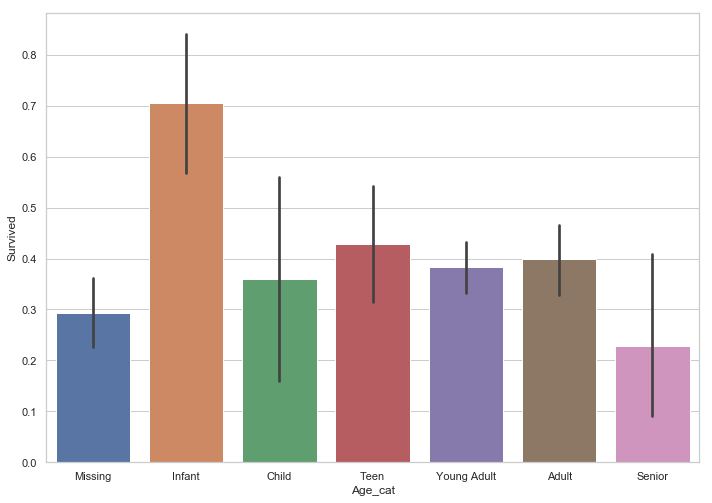

In [179]:
age_cuts = [-1, 0, 5, 12, 18, 35, 60, 100]
age_labels = ["Missing", "Infant", "Child", "Teen", "Young Adult", "Adult", "Senior"]
df_train = pipeline.attrib_cats(df_train, "Age", "Age_cat", age_cuts, age_labels) 
ax = sns.barplot(x='Age_cat', y='Survived', data=df_train)

Looks like my initial hunch of the very young not faring well was not so accurate. Infants in general seem to have done ok, with the other age groups not showing much of a clear pattern other than seniors faring the worst.

### Passenger Class (`Pclass`) and Fare (`fare`)
The Titanic movie taught me that the poor were treated quite poorly and were much more likely to not survive this tragedy. Probably not the most scientific hunch, but I would guess this is an important factor here. Fare likely has a similar response to survival and may indeed serve as a proxy to `pclass`.

We'll also separate by sex to see if the previous trend we saw continues to hold true.


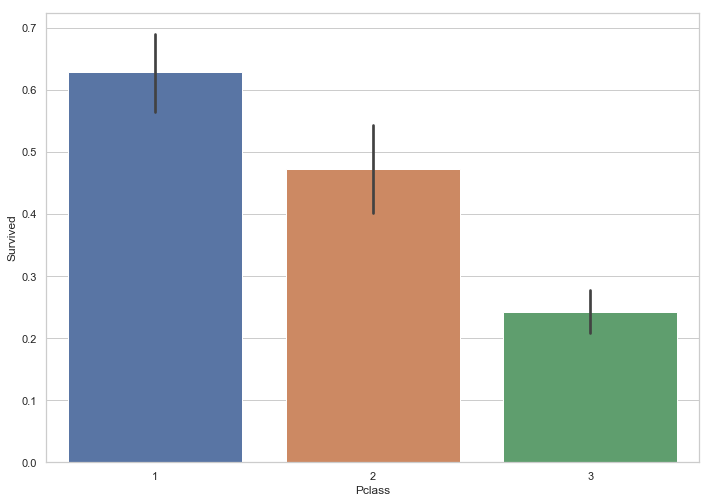

In [118]:
sns.set(style="whitegrid")
ax = sns.barplot(x='Pclass', y='Survived', data=df_train)

In [119]:
df_survival_class_sex = df_train[['Pclass', 'Sex', 'Survived']].groupby(['Pclass', 'Sex']).mean()
df_survival_class_sex.reset_index(inplace=True)
df_survival_class_sex

,Pclass,Sex,Survived
0,1,female,0.968085
1,1,male,0.368852
2,2,female,0.921053
3,2,male,0.157407
4,3,female,0.500000
5,3,male,0.135447


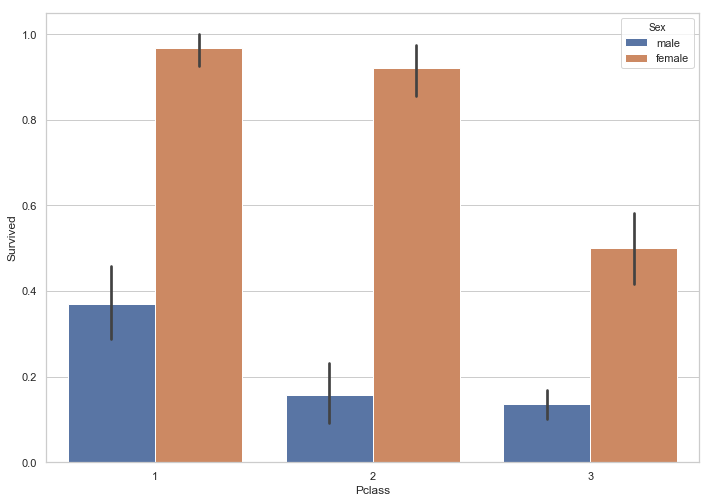

In [120]:
ax = sns.barplot(x='Pclass', y='Survived', hue='Sex', data=df_train)

So it looks like women in the upper classes (1 and 2) fared much better overall than any other group. In fact, if you're a female in classes 1 or 2, you stand a $>90\%$ chance of surviving. Women in general did better overall, but in lower classes for men, things look pretty grim. I guess social science via blockbuster Hollywood movie may have some validity after all!

### Family Relations (`sibsp` and `parch`)



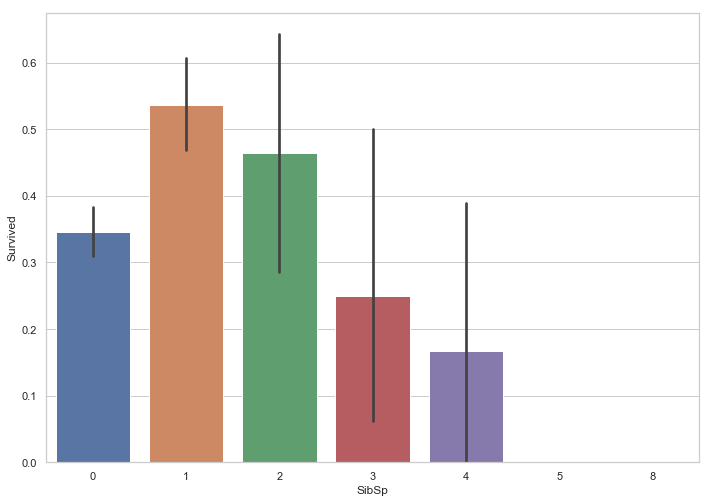

In [121]:
ax = sns.barplot(x='SibSp', y='Survived',  data=df_train)

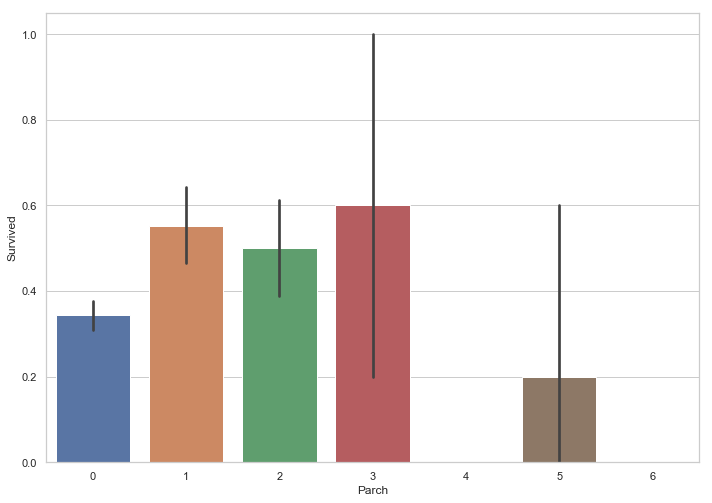

In [124]:
ax = sns.barplot(x='Parch', y='Survived', data=df_train)

In [86]:
df_train['Fare_Bins'] = pd.cut(df_train['Fare'], 8)

### Fare (`Fare`)
Binning fares into groups seems to show a distinct correlation with survival rates: the more expensive your ticket, the more likely you were to survive.

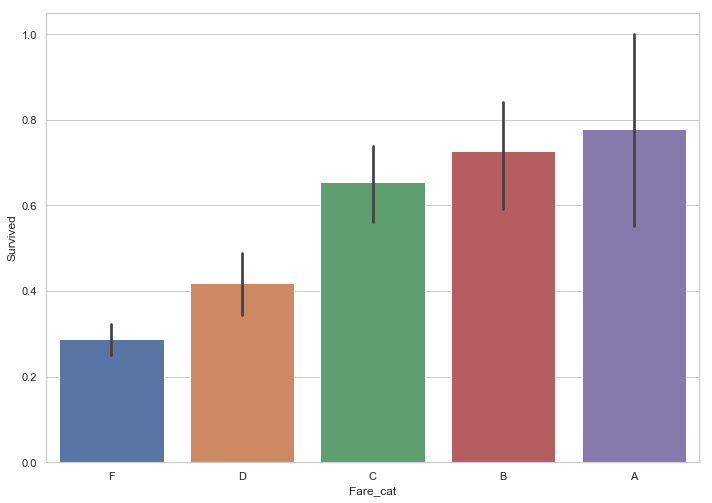

In [178]:
fare_cuts = [-1, 25, 50, 100, 250, 800]
fare_labels = ["F", "D", "C", "B", "A"]
df_train = pipeline.attrib_cats(df_train, "Fare", "Fare_cat", fare_cuts, fare_labels) 
ax = sns.barplot(x='Fare_cat', y='Survived', data=df_train)

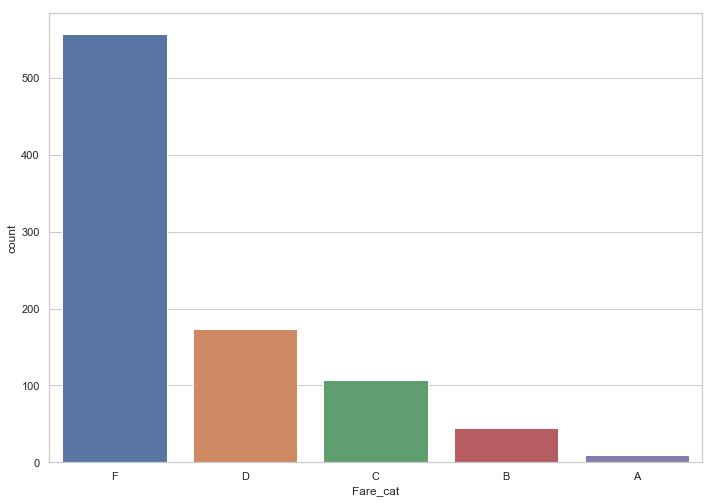

In [153]:
ax = sns.countplot(x='Fare_cat', data=df_train)

In [154]:
df_train[['Survived', 'Fare_cat']].groupby(['Fare_cat']).count()

,Survived
Fare_cat,
F,557
D,174
C,107
B,44
A,9


## Data Cleaning Part II, Pipelining and Creating Categories and Attributes

Fortunately, this dataset is pretty clean, mostly numeric, and requires not too much prep other than what we already did with imputting values. That being said, for completeness, we'll create some functions and a pipeline to process the data so that it's consistent and repeateable. Additionally, we'll think up some useful categories and attributes which might help identify additional patterns so the ML algorithm we choose will work better.

In [229]:
import importlib
importlib.reload(pipeline)


<module 'src.pipeline' from '/Users/kai/dev/kaggle-titanic/src/pipeline.py'>

In [230]:
cat_attribs = ['Sex', 'Pclass', 'Age_cat', 'Fare_cat']
num_attribs = ['SibSp', 'Parch']
pipeline.DataFramePipeline(cat_attribs, num_attribs).full_pipeline.fit_transform(df_train).shape

(891, 17)

In [166]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_cat', 'Fare_cat'],
      dtype='object')

### Run a model
Since we don't have labels for the test set, we'll split the training set into two groups so we don't have to keep submitting to Kaggle to get a sense of how our models is doing.

In [231]:
from sklearn.model_selection import train_test_split

columns = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 
           'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_cat', 'Fare_cat']
all_X = df_train[columns]
all_y = df_train['Survived']
train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size=0.20, random_state=42)

In [232]:
train_X_tr = pipeline.DataFramePipeline(cat_attribs, num_attribs).full_pipeline.fit_transform(train_X)
test_X_tr = pipeline.DataFramePipeline(cat_attribs, num_attribs).full_pipeline.fit_transform(test_X)

In [252]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, oob_score=True, random_state=42)
rf.fit(train_X_tr, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [253]:
predicted = rf.predict(test_X_tr)

In [254]:
from sklearn.metrics import accuracy_score

accuracy_score(test_y, predicted)

0.8491620111731844

In [239]:
df_test = pipeline.attrib_cats(df_test, "Age", "Age_cat", age_cuts, age_labels)
df_test = pipeline.attrib_cats(df_test, "Fare", "Fare_cat", fare_cuts, fare_labels) 
test_actual_X_tr = pipeline.DataFramePipeline(cat_attribs, num_attribs).full_pipeline.fit_transform(df_test)

In [240]:
predicted_real_test = rf.predict(test_actual_X_tr)

In [241]:
df_predict = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived':predicted_real_test[:]})

In [242]:
df_predict.to_csv('kaggle-titanic-submission.csv', index=False)

In [243]:
all_X

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat,Fare_cat
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young Adult,F
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult,F
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult,C
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult,F
5,6,3,"Moran, Mr. James",male,-0.5,0,0,330877,8.4583,NaN,Q,Missing,F
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Adult,C
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Infant,F
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Young Adult,F
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Teen,D


In [244]:
all_X_tr = pipeline.DataFramePipeline(cat_attribs, num_attribs).full_pipeline.fit_transform(all_X)

In [245]:
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()
scores = cross_val_score(rf, all_X_tr, all_y, cv=10)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

/Users/kai/anaconda3/envs/kai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kai/anaconda3/envs/kai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kai/anaconda3/envs/kai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kai/anaconda3/envs/kai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kai/anaco

[0.74157303 0.74444444 0.76666667 0.78651685 0.80898876 0.82022472
 0.82022472 0.86516854 0.875      0.88764045]
0.8116448189762796


/Users/kai/anaconda3/envs/kai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kai/anaconda3/envs/kai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kai/anaconda3/envs/kai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
